In [1]:
# SETUP AND DATASET INSPECTION
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import json

drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/CircuitGuard_Project/new PCB _ds.zip" -d /content/

DATASET_PATH = '/content/new PCB _ds'
TEMPLATE_DIR = f'{DATASET_PATH}/PCB_USED'
TEST_BASE_DIR = f'{DATASET_PATH}/images'

OUTPUT_BASE = '/content/processed_output'
DIFF_MAPS_DIR = f'{OUTPUT_BASE}/difference_maps'
MASKS_DIR = f'{OUTPUT_BASE}/defect_masks'

DEFECT_CATEGORIES = ['Short', 'Open_circuit', 'Mouse_bite', 'Spur', 'Spurious_copper', 'Missing_hole']

print("🔍 DATASET INSPECTION")

template_files = glob.glob(f"{TEMPLATE_DIR}/*.JPG") + glob.glob(f"{TEMPLATE_DIR}/*.jpg")
print(f"\n✓ Template Images: {len(template_files)}")

dataset_stats = {}
total_test_images = 0

for defect in DEFECT_CATEGORIES:
    defect_dir = f"{TEST_BASE_DIR}/{defect}"
    if os.path.exists(defect_dir):
        files = glob.glob(f"{defect_dir}/*.jpg") + glob.glob(f"{defect_dir}/*.JPG")
        dataset_stats[defect] = len(files)
        total_test_images += len(files)
        print(f"  - {defect}: {len(files)} images")
    else:
        dataset_stats[defect] = 0
        print(f"  - {defect}: FOLDER NOT FOUND ⚠️")

print(f"📊 TOTAL TEST IMAGES: {total_test_images}")

with open('/content/dataset_inspection_report.json', 'w') as f:
    json.dump({
        'total_templates': len(template_files),
        'total_test_images': total_test_images,
        'category_breakdown': dataset_stats
    }, f, indent=2)

print("✅ Dataset inspection complete!")
print("📄 Report saved: /content/dataset_inspection_report.json")


Mounted at /content/drive
🔍 DATASET INSPECTION

✓ Template Images: 10
  - Short: 116 images
  - Open_circuit: 116 images
  - Mouse_bite: 115 images
  - Spur: 115 images
  - Spurious_copper: 116 images
  - Missing_hole: 115 images
📊 TOTAL TEST IMAGES: 693
✅ Dataset inspection complete!
📄 Report saved: /content/dataset_inspection_report.json


In [2]:
# CORE PROCESSING FUNCTIONS
def preprocess_image(img):
    img = cv2.equalizeHist(img)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return img

def align_images(template_path, test_path):
    template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    test_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)

    if template_img is None or test_img is None:
        return None, None

    # Preprocessing images
    template_preprocessed = preprocess_image(template_img)
    test_preprocessed = preprocess_image(test_img)

    # ORB feature detection
    orb = cv2.ORB_create(nfeatures=5000)
    keypoints1, descriptors1 = orb.detectAndCompute(template_preprocessed, None)
    keypoints2, descriptors2 = orb.detectAndCompute(test_preprocessed, None)

    if descriptors1 is None or descriptors2 is None:
        return None, None

    # Matching features
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Use top 5% matches
    num_good_matches = max(int(len(matches) * 0.05), 4)
    good_matches = matches[:num_good_matches]

    if len(good_matches) < 4:
        return None, None

    # Extract matched points
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Finding homography
    h, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    if h is None:
        return None, None

    # Warp test image
    height, width = template_img.shape
    aligned_img = cv2.warpPerspective(test_img, h, (width, height))

    return template_img, aligned_img

def compute_difference_and_threshold(template_img, aligned_img):
    # Computing difference
    diff_map = cv2.absdiff(template_img, aligned_img)

    # Applying Gaussian blur
    blurred_diff = cv2.GaussianBlur(diff_map, (5, 5), 0)

    # Otsu's thresholding
    otsu_value, threshold_mask = cv2.threshold(
        blurred_diff, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(threshold_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return diff_map, cleaned_mask, otsu_value

print("Core functions defined!")


Core functions defined!


In [3]:
# Creating Difference Maps
def process_single_image_pair(template_file, test_file, defect_type, save_outputs=True):
    test_filename = os.path.basename(test_file)
    base_name = os.path.splitext(test_filename)[0]

    result = {
        'test_image': test_filename,
        'defect_type': defect_type,
        'status': 'failed',
        'otsu_threshold': None,
        'mean_difference': None
    }

    try:
        # Aligning images
        template_img, aligned_img = align_images(template_file, test_file)

        if aligned_img is None:
            result['error'] = 'Alignment failed'
            return result

        # Computing difference and threshold
        diff_map, cleaned_mask, otsu_value = compute_difference_and_threshold(
            template_img, aligned_img
        )

        # Calculating metrics
        mean_diff = np.mean(diff_map)

        result['status'] = 'success'
        result['otsu_threshold'] = float(otsu_value)
        result['mean_difference'] = float(mean_diff)

        if save_outputs:
            diff_dir = f"{DIFF_MAPS_DIR}/{defect_type}"
            mask_dir = f"{MASKS_DIR}/{defect_type}"
            os.makedirs(diff_dir, exist_ok=True)
            os.makedirs(mask_dir, exist_ok=True)

            cv2.imwrite(f"{diff_dir}/{base_name}_diff.jpg", diff_map)

            cv2.imwrite(f"{mask_dir}/{base_name}_mask.jpg", cleaned_mask)

        return result

    except Exception as e:
        result['error'] = str(e)
        return result

def process_entire_dataset():
    print("🚀 STARTING FULL DATASET PROCESSING")
    print("\nThis will process ALL images and create:")
    print("  1. Difference maps for each defect image")
    print("  2. Cleaned masks for each defect image")
    print("\nProcessing in BATCH mode...\n")

    all_results = {}
    total_processed = 0
    total_successful = 0
    total_failed = 0

    for defect_type in DEFECT_CATEGORIES:
        test_dir = f"{TEST_BASE_DIR}/{defect_type}"

        if not os.path.exists(test_dir):
            print(f"⚠️  Skipping {defect_type} - folder not found")
            continue

        print(f"\n📂 Processing {defect_type} category...")
        print("-" * 60)

        test_files = sorted(glob.glob(f"{test_dir}/*.jpg") + glob.glob(f"{test_dir}/*.JPG"))

        category_results = []
        success_count = 0
        fail_count = 0

        for test_file in tqdm(test_files, desc=f"  {defect_type}"):
            test_filename = os.path.basename(test_file)
            template_num = test_filename.split('_')[0]
            template_file = f"{TEMPLATE_DIR}/{template_num}.JPG"

            if not os.path.exists(template_file):
                fail_count += 1
                continue

            result = process_single_image_pair(template_file, test_file, defect_type, save_outputs=True)

            category_results.append(result)

            if result['status'] == 'success':
                success_count += 1
            else:
                fail_count += 1

        all_results[defect_type] = category_results
        total_processed += len(test_files)
        total_successful += success_count
        total_failed += fail_count

        print(f"  ✅ Success: {success_count} | ❌ Failed: {fail_count}")

    report = {
        'total_processed': total_processed,
        'total_successful': total_successful,
        'total_failed': total_failed,
        'success_rate': (total_successful / total_processed * 100) if total_processed > 0 else 0,
        'category_results': all_results
    }

    with open(f"{OUTPUT_BASE}/module1_processing_report.json", 'w') as f:
        json.dump(report, f, indent=2)

    print(" DATASET PROCESSING COMPLETE!")
    print(f"\n📊 SUMMARY:")
    print(f"  Total Processed: {total_processed}")
    print(f"  Successful: {total_successful}")
    print(f"  Failed: {total_failed}")
    print(f"  Success Rate: {report['success_rate']:.2f}%")
    print(f"\n📁 Outputs saved to:")
    print(f"  - Difference maps: {DIFF_MAPS_DIR}/")
    print(f"  - Defect masks: {MASKS_DIR}/")
    print(f"  - Report: {OUTPUT_BASE}/module1_processing_report.json")

    return report

report = process_entire_dataset()


🚀 STARTING FULL DATASET PROCESSING

This will process ALL images and create:
  1. Difference maps for each defect image
  2. Cleaned masks for each defect image

Processing in BATCH mode...


📂 Processing Short category...
------------------------------------------------------------


  Short: 100%|██████████| 116/116 [02:29<00:00,  1.29s/it]


  ✅ Success: 116 | ❌ Failed: 0

📂 Processing Open_circuit category...
------------------------------------------------------------


  Open_circuit: 100%|██████████| 116/116 [02:21<00:00,  1.22s/it]


  ✅ Success: 116 | ❌ Failed: 0

📂 Processing Mouse_bite category...
------------------------------------------------------------


  Mouse_bite: 100%|██████████| 115/115 [02:22<00:00,  1.24s/it]


  ✅ Success: 115 | ❌ Failed: 0

📂 Processing Spur category...
------------------------------------------------------------


  Spur: 100%|██████████| 115/115 [02:22<00:00,  1.24s/it]


  ✅ Success: 115 | ❌ Failed: 0

📂 Processing Spurious_copper category...
------------------------------------------------------------


  Spurious_copper: 100%|██████████| 116/116 [02:21<00:00,  1.22s/it]


  ✅ Success: 116 | ❌ Failed: 0

📂 Processing Missing_hole category...
------------------------------------------------------------


  Missing_hole: 100%|██████████| 115/115 [02:22<00:00,  1.24s/it]

  ✅ Success: 115 | ❌ Failed: 0
 DATASET PROCESSING COMPLETE!

📊 SUMMARY:
  Total Processed: 693
  Successful: 693
  Failed: 0
  Success Rate: 100.00%

📁 Outputs saved to:
  - Difference maps: /content/processed_output/difference_maps/
  - Defect masks: /content/processed_output/defect_masks/
  - Report: /content/processed_output/module1_processing_report.json


In [4]:
!zip -r /content/difference_maps.zip {DIFF_MAPS_DIR}

!zip -r /content/defect_masks.zip {MASKS_DIR}

!zip /content/reports.zip /content/dataset_inspection_report.json {OUTPUT_BASE}/module1_processing_report.json

print("\n Ready to download:")
print("  1. difference_maps.zip (all difference maps)")
print("  2. defect_masks.zip (all cleaned masks)")
print("  3. reports.zip (processing reports)")

from google.colab import files
files.download('/content/difference_maps.zip')
files.download('/content/defect_masks.zip')
files.download('/content/reports.zip')

print("\n✅ All downloads complete!")


  adding: content/processed_output/difference_maps/ (stored 0%)
  adding: content/processed_output/difference_maps/Open_circuit/ (stored 0%)
  adding: content/processed_output/difference_maps/Open_circuit/10_open_circuit_02_diff.jpg (deflated 3%)
  adding: content/processed_output/difference_maps/Open_circuit/01_open_circuit_16_diff.jpg (deflated 2%)
  adding: content/processed_output/difference_maps/Open_circuit/11_open_circuit_09_diff.jpg (deflated 3%)
  adding: content/processed_output/difference_maps/Open_circuit/07_open_circuit_06_diff.jpg (deflated 3%)
  adding: content/processed_output/difference_maps/Open_circuit/04_open_circuit_12_diff.jpg (deflated 3%)
  adding: content/processed_output/difference_maps/Open_circuit/01_open_circuit_09_diff.jpg (deflated 2%)
  adding: content/processed_output/difference_maps/Open_circuit/08_open_circuit_08_diff.jpg (deflated 3%)
  adding: content/processed_output/difference_maps/Open_circuit/11_open_circuit_07_diff.jpg (deflated 3%)
  adding: c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All downloads complete!


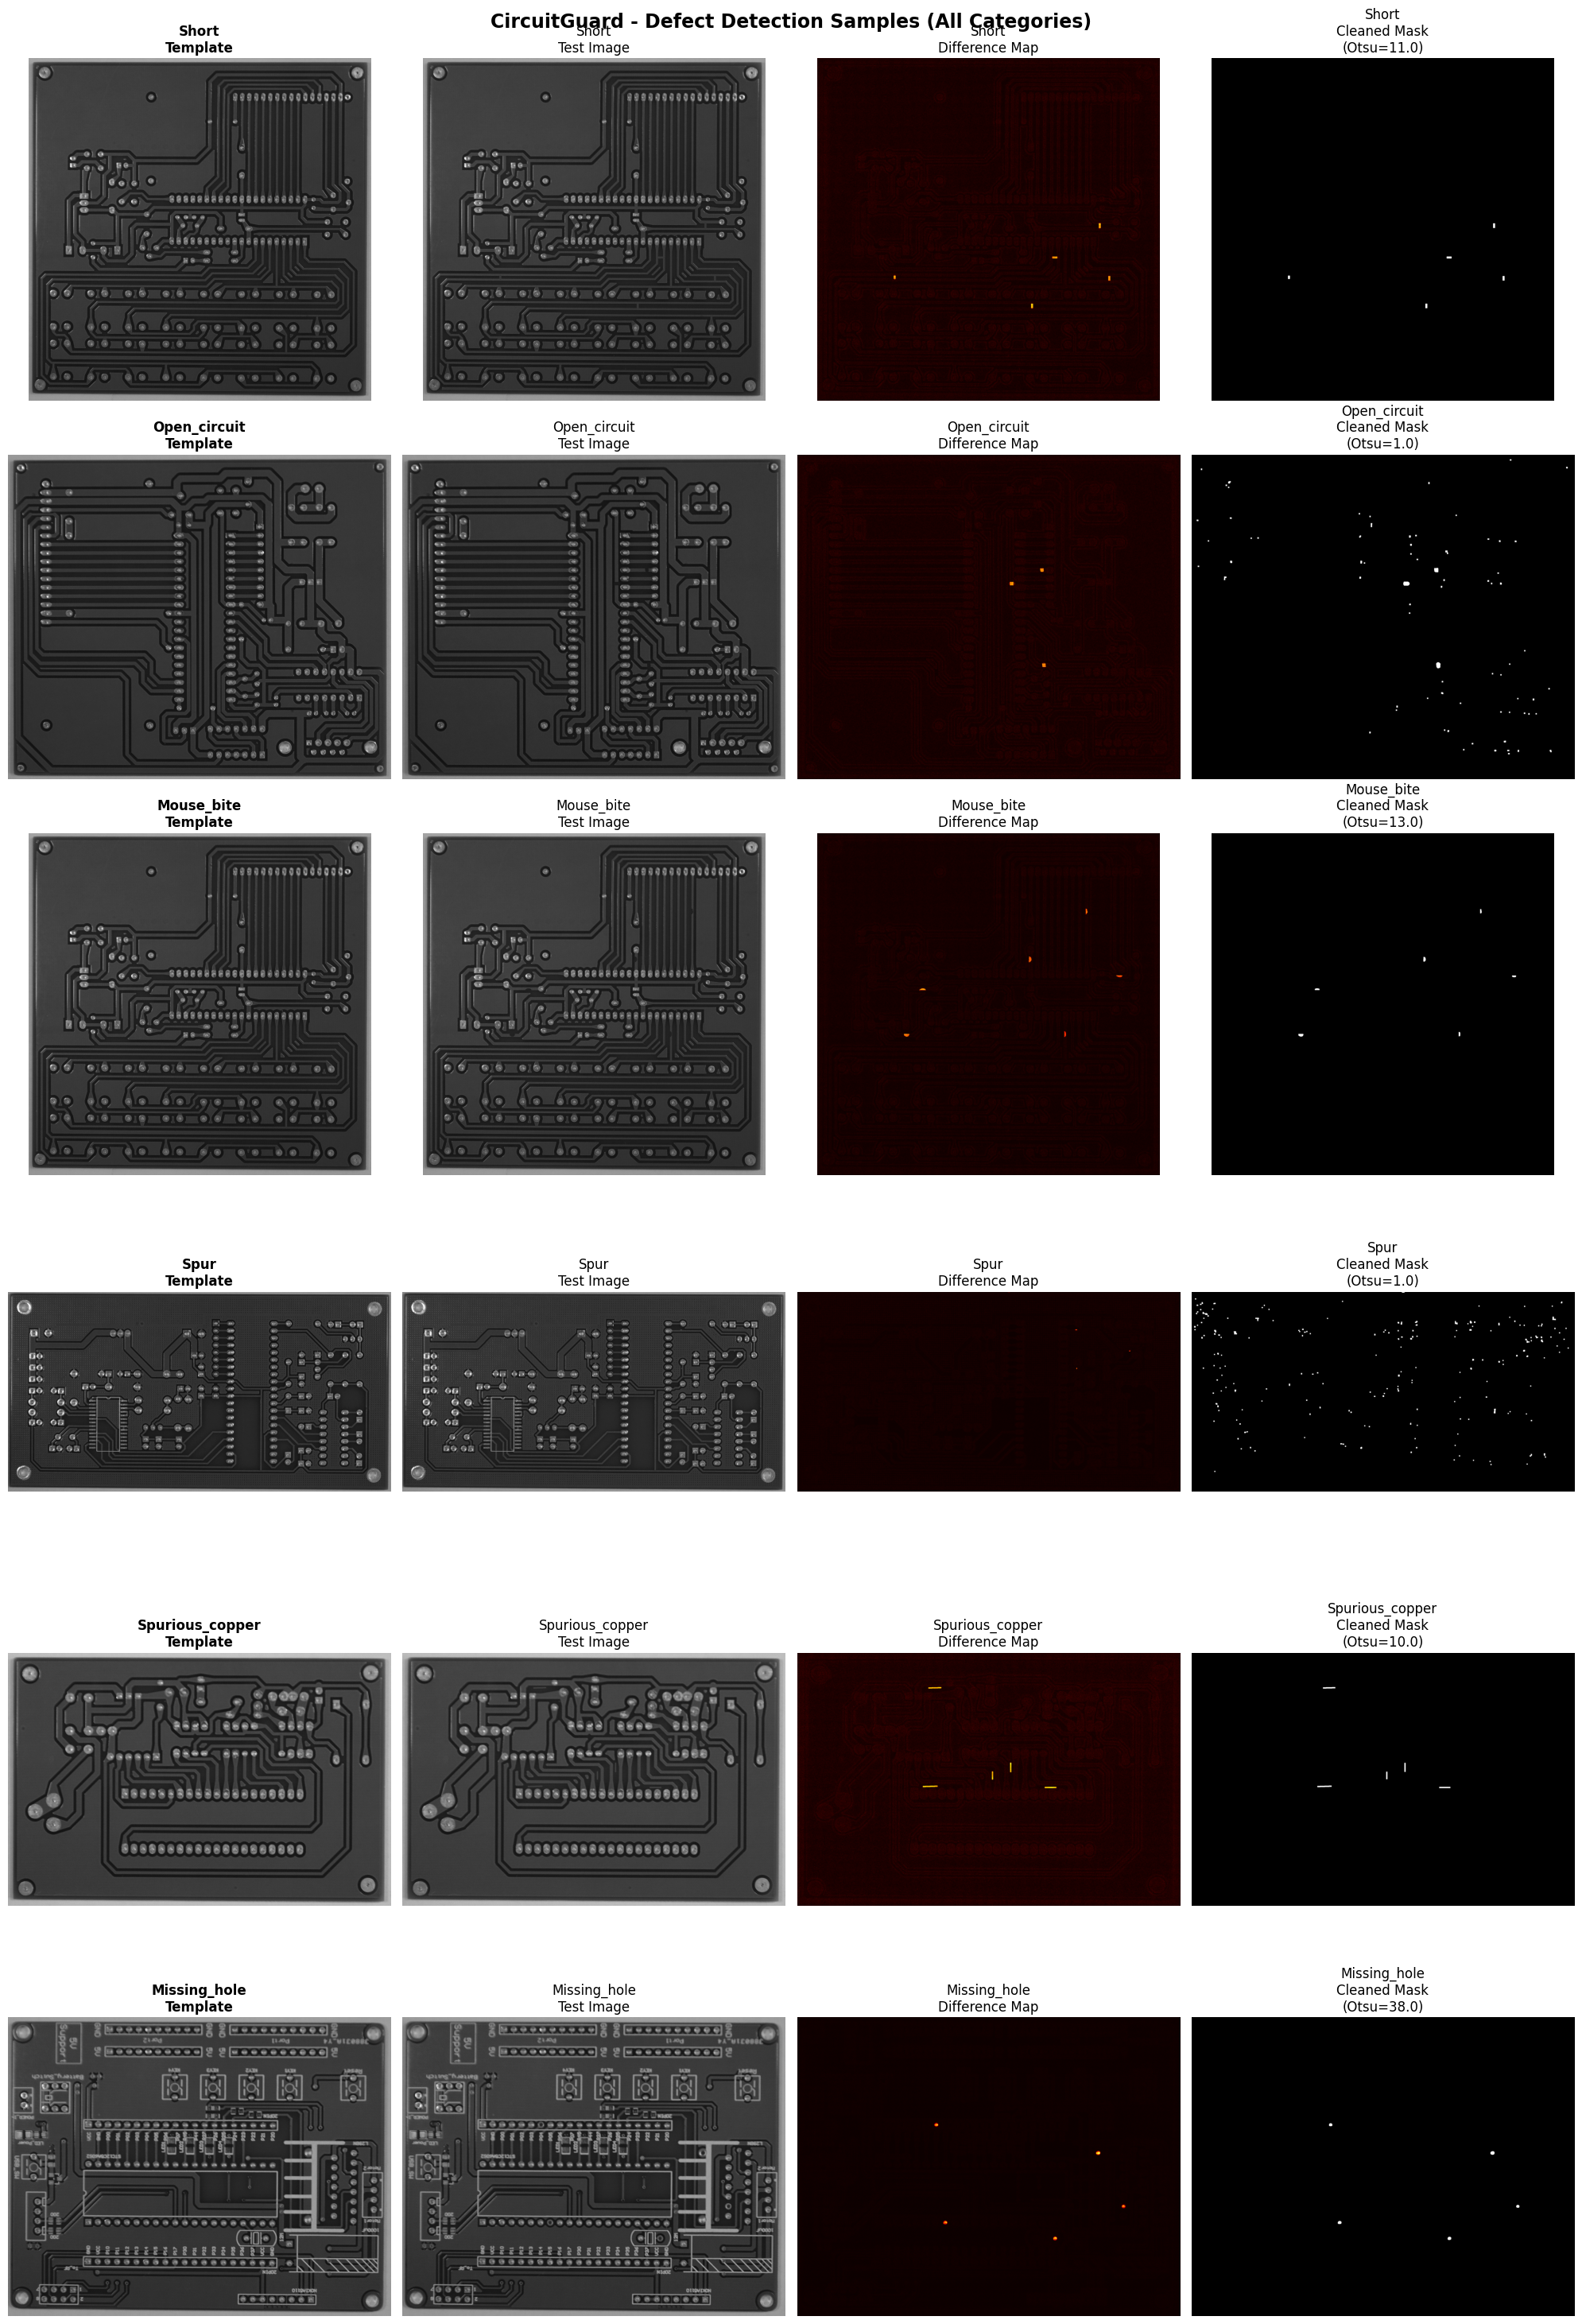

✅ Sample visualization saved: /content/processed_output/module1_all_defect_samples.png


In [5]:
def create_module1_samples():
    """
    Creating sample visualization showing all 6 defect categories
    """
    fig, axes = plt.subplots(6, 4, figsize=(20, 30))
    fig.suptitle('CircuitGuard - Defect Detection Samples (All Categories)',
                 fontsize=17, fontweight='bold')

    for idx, defect_type in enumerate(DEFECT_CATEGORIES):
        test_dir = f"{TEST_BASE_DIR}/{defect_type}"

        if not os.path.exists(test_dir):
            continue

        test_files = glob.glob(f"{test_dir}/*.jpg") + glob.glob(f"{test_dir}/*.JPG")

        if len(test_files) == 0:
            continue

        sample_file = test_files[0]
        test_filename = os.path.basename(sample_file)
        template_num = test_filename.split('_')[0]
        template_file = f"{TEMPLATE_DIR}/{template_num}.JPG"
        template_img, aligned_img = align_images(template_file, sample_file)

        if aligned_img is None:
            continue

        diff_map, cleaned_mask, otsu_value = compute_difference_and_threshold(
            template_img, aligned_img
        )

        axes[idx, 0].imshow(template_img, cmap='gray')
        axes[idx, 0].set_title(f'{defect_type}\nTemplate', fontsize=12, fontweight='bold')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(aligned_img, cmap='gray')
        axes[idx, 1].set_title(f'{defect_type}\nTest Image', fontsize=12)
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(diff_map, cmap='hot')
        axes[idx, 2].set_title(f'{defect_type}\nDifference Map', fontsize=12)
        axes[idx, 2].axis('off')

        axes[idx, 3].imshow(cleaned_mask, cmap='gray')
        axes[idx, 3].set_title(f'{defect_type}\nCleaned Mask\n(Otsu={otsu_value:.1f})', fontsize=12)
        axes[idx, 3].axis('off')

    plt.tight_layout()
    plt.savefig(f'{OUTPUT_BASE}/module1_all_defect_samples.png',
                dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Sample visualization saved: {OUTPUT_BASE}/module1_all_defect_samples.png")

create_module1_samples()
